In [20]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!ls /content/drive/MyDrive/dryfruitsDataset.rar

/content/drive/MyDrive/dryfruitsDataset.rar


In [23]:
!unrar x /content/drive/MyDrive/dryfruitsDataset.rar /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_182.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1820.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1821.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1822.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1823.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1824.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1825.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1826.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1827.jpg      85%  OK 
Extracting  /content/DryFruits_Dataset/Walnut/Grade_A/walnut_A_1828.jpg      85%  OK 


In [24]:
print("--- Dataset Extracted ---")
!ls /content/

--- Dataset Extracted ---
drive  DryFruits_Dataset  sample_data


In [41]:
import os
DATASET_DIR = '/content/DryFruits_Dataset'
print(os.listdir(DATASET_DIR))

['AlmondGrade_A', 'CashewGrade_B', 'RaisinGrade_A', 'CashewGrade_A', 'AlmondGrade_B', 'PistachioGrade_A', 'RaisinGrade_B', 'WalnutGrade_A', 'CashewGrade_C']


In [61]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# ----------------- Parameters -----------------
IMG_SIZE = 224          # Your images are 720x720
BATCH_SIZE = 32          # Reduce if GPU memory is limited
DATASET_DIR = '/content/DryFruits_Dataset'
EPOCHS = 50
MODEL_FILE = 'resnet50_dryfruits.h5'

# Count number of classes
NUM_CLASSES = len([f for f in os.listdir(DATASET_DIR)
                   if os.path.isdir(os.path.join(DATASET_DIR, f))])

print(NUM_CLASSES)

9


In [62]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <-- This is still required
    validation_split=0.2  # Split 20% for validation
)

# The validation generator is the same (just preprocessing)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# --- Create the generators from the directory ---
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Set as training data
)

val_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Set as validation data
)

# --- Get Class Count Automatically ---
NUM_CLASSES = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Found {NUM_CLASSES} classes: {class_names}")

Found 34080 images belonging to 9 classes.
Found 8520 images belonging to 9 classes.
Found 9 classes: ['AlmondGrade_A', 'AlmondGrade_B', 'CashewGrade_A', 'CashewGrade_B', 'CashewGrade_C', 'PistachioGrade_A', 'RaisinGrade_A', 'RaisinGrade_B', 'WalnutGrade_A']


In [63]:
# Model Setup
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 2. FREEZE the base model
base_model.trainable = False

# 3. Build your new model "head"
inputs = base_model.input
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x) # An extra dense layer helps
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=output)

In [65]:
# Compile the model for Stage 1
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # A normal LR is fine here
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 263,433 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [66]:
# Define Callbacks
# We only use EarlyStopping here
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
# Train the head
history_stage_1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # 10 epochs is usually enough for the head
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 270s 241ms/step - accuracy: 0.9322 - loss: 0.2162 - val_accuracy: 0.9878 - val_loss: 0.0366
Epoch 2/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 210s 197ms/step - accuracy: 0.9911 - loss: 0.0259 - val_accuracy: 0.9921 - val_loss: 0.0225
Epoch 3/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 204s 191ms/step - accuracy: 0.9927 - loss: 0.0217 - val_accuracy: 0.9865 - val_loss: 0.0415
Epoch 4/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 206s 194ms/step - accuracy: 0.9927 - loss: 0.0212 - val_accuracy: 0.9867 - val_loss: 0.0485
Epoch 5/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 205s 193ms/step - accuracy: 0.9942 - loss: 0.0162 - val_accuracy: 0.9893 - val_loss: 0.0353
Epoch 6/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 202s 190ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.9942 - val_loss: 0.0158
Epoch 7/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 199s 187ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9870 - val_loss: 0.0455
Epoch 8/10
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 209s 196ms/step - ac

In [68]:
# UNFREEZE the base model
base_model.trainable = True

# Re-compile the model with a VERY LOW learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # <-- Critical!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define your final checkpoint callback
checkpoint = ModelCheckpoint(
    MODEL_FILE,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# reuse the early_stop callback from before
callbacks_list = [early_stop, checkpoint]

print("--- STAGE 2: Fine-tuning the entire model ---")

# Train the full model
history_stage_2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,  # train for the full 50 (or until it stops)
    initial_epoch=history_stage_1.epoch[-1], # Start from where we left off
    callbacks=callbacks_list
)

print(f"--- Training Complete. Best model saved to {MODEL_FILE} ---")

--- STAGE 2: Fine-tuning the entire model ---
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9508 - loss: 0.2678
Epoch 10: val_accuracy improved from -inf to 0.99108, saving model to resnet50_dryfruits.h5


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 409s 332ms/step - accuracy: 0.9508 - loss: 0.2677 - val_accuracy: 0.9911 - val_loss: 0.0421
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9973 - loss: 0.0096
Epoch 11: val_accuracy did not improve from 0.99108
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 355s 328ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9864 - val_loss: 0.0987
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9982 - loss: 0.0066
Epoch 12: val_accuracy did not improve from 0.99108
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 350s 328ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9858 - val_loss: 0.0736
Epoch 13/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9992 - loss: 0.0031
Epoch 13: val_accuracy improved from 0.99108 to 0.99730, saving model to resnet50_dryfruits.h5


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 351s 330ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9973 - val_loss: 0.0122
Epoch 14/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9996 - loss: 0.0019
Epoch 14: val_accuracy did not improve from 0.99730
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 351s 329ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9946 - val_loss: 0.0232
Epoch 15/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9990 - loss: 0.0037
Epoch 15: val_accuracy did not improve from 0.99730
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 351s 330ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9965 - val_loss: 0.0159
Epoch 16/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9995 - loss: 0.0021
Epoch 16: val_accuracy did not improve from 0.99730
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 350s 329ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9952 - val_loss: 0.0197
Epoch 17/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9995 - l

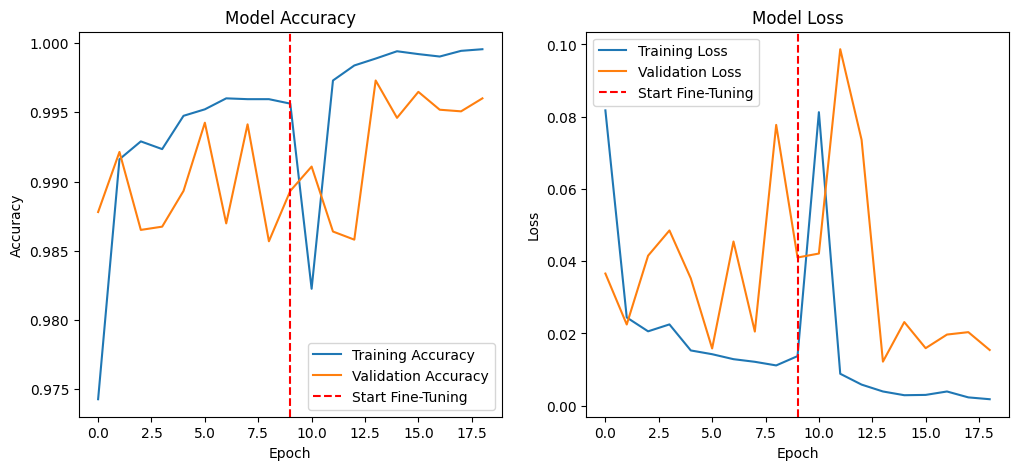

In [69]:
# Combine the history from both stages
history = {
    'accuracy': history_stage_1.history['accuracy'] + history_stage_2.history['accuracy'],
    'val_accuracy': history_stage_1.history['val_accuracy'] + history_stage_2.history['val_accuracy'],
    'loss': history_stage_1.history['loss'] + history_stage_2.history['loss'],
    'val_loss': history_stage_1.history['val_loss'] + history_stage_2.history['val_loss'],
}

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.axvline(history_stage_1.epoch[-1], color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axvline(history_stage_1.epoch[-1], color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [76]:
# Example inference and testing
from google.colab import files

print("Please upload a test image:")
uploaded = files.upload()

# Get the filename of the uploaded file
test_image_path = list(uploaded.keys())[0]

print(f"\nUploaded '{test_image_path}' successfully.")

Please upload a test image:


Saving IMG_20251005_235151268_HDR.jpg to IMG_20251005_235151268_HDR.jpg

Uploaded 'IMG_20251005_235151268_HDR.jpg' successfully.


Loading trained model...


Model loaded successfully.
Class names: {0: 'AlmondGrade_A', 1: 'AlmondGrade_B', 2: 'CashewGrade_A', 3: 'CashewGrade_B', 4: 'CashewGrade_C', 5: 'PistachioGrade_A', 6: 'RaisinGrade_A', 7: 'RaisinGrade_B', 8: 'WalnutGrade_A'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


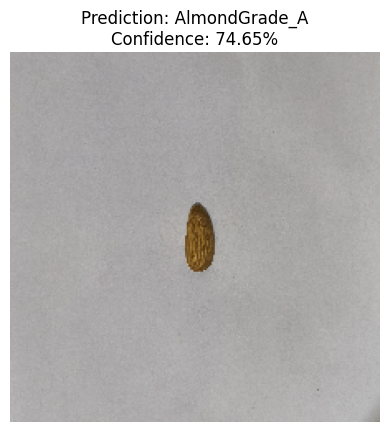

Predicted Class: AlmondGrade_A
Confidence: 74.65%


In [77]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Define Constants
MODEL_PATH = 'resnet50_dryfruits.h5' # Or .h5 if you didn't change it
IMG_SIZE = 224

# Load the Trained Model
print("Loading trained model...")
model = load_model(MODEL_PATH)
print("Model loaded successfully.")

# Get Class Names
# need to map the model's output (an index) back to a class name
# (Assumes your 'train_generator' is still in memory from the training notebook)
class_indices = train_generator.class_indices
# Create a reverse mapping from index to class name
class_names = {v: k for k, v in class_indices.items()}

print(f"Class names: {class_names}")

# Load and Preprocess the Test Image

# Load the image from the path, resizing it to 224x224
img = image.load_img(test_image_path, target_size=(IMG_SIZE, IMG_SIZE))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to create a "batch" of 1
# Shape changes from (224, 224, 3) to (1, 224, 224, 3)
img_batch = np.expand_dims(img_array, axis=0)

# **IMPORTANT: Preprocess the image exactly as you did for training**
img_preprocessed = preprocess_input(img_batch)

# Make the Prediction
prediction = model.predict(img_preprocessed)

# Decode the Prediction
# `prediction` is an array of probabilities for each class
# Use np.argmax to find the index of the class with the highest probability
predicted_index = np.argmax(prediction[0])
predicted_class_name = class_names[predicted_index]
confidence = np.max(prediction[0])

# Show the Result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence*100:.2f}%")
plt.show()

print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence*100:.2f}%")